In [101]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict

filenames=['DS0003','DS0006','DS0009','DS0012','DS0015','DS0017','DS0019','DS0021', \
           'DS0024','DS0026','DS0028','DS0030','DS0032','DS0034']

# filenames=['DS0003','DS0006','DS0009','DS0012','DS0015','DS0017']
cohorts=np.arange(1,16).astype(str).tolist()
# _=cohorts.pop(8) # 9th cohort missing
data = {}
data_size=0
fpath='C:\\Users\\tolut\\Box Sync\\Documents\\PythonScripts\\dataIncubator\\ICPSR_23380\\'
for index, file in enumerate(filenames):
    fname = fpath+file+'\\23380-'+file[2:]+'-Data.tsv'
    temp_pd=pd.read_csv(fname,sep='\t',na_values=np.nan,dtype=str)
    temp_pd['cohort']=cohorts[index]
    data[cohorts[index]]=temp_pd
    data_size+=os.stat(fname).st_size

    
data_size=data_size/1e6

columnNames={}
for c in cohorts:
    columnNames[c]= data[c].columns
    
for index, c in enumerate(cohorts):
    prefix1='C'+ c
    prefix2='R'+ c
    prefix3='P'+ c
    st=len(prefix1)
    temp_columnNames=[ x.replace(c,'_')  if (x.startswith(prefix1)|x.startswith(prefix2) |x.startswith(prefix3)) \
                      else x  for x in data[c].columns]
    data[c].columns=temp_columnNames

d_dict=pd.ExcelFile('insurance.xlsx').parse('Sheet1')
# change the PLREG column name in cohort 6
data['6'].rename(columns={'P_PLREG':'PLREG'},inplace=True)


In [106]:
from collections import defaultdict

for c in cohorts:
    data[c].replace(r'\s+', np.nan, regex=True,inplace=True)

req_cols=data['1'].columns
nData={}
for c in cohorts:
#     keep_col=list(set(data[c].columns) & set(req_cols))
    rem_col=list(set(data[c].columns) - set(req_cols))
    temp_data=data[c].copy()
    if rem_col:
        temp_data.drop(rem_col,axis=1,inplace=True)
    nData[c]=temp_data

cat_dict=dict(zip(d_dict.feature,d_dict.Category))
longName_dict=dict(zip(d_dict.feature,d_dict['long name']))
Categories=list(set(cat_dict.values()))
trans_dict=defaultdict(dict)
for feature in d_dict.feature:
    temp_allowed = d_dict.loc[d_dict.feature==feature,'allowed']
    temp_trans=d_dict.loc[d_dict.feature==feature,'transformed']
    if not(pd.isnull(temp_trans.values) | pd.isnull(temp_allowed.values)):
        keys=temp_allowed.values[0].split(',')
        values=list(map(int,temp_trans.values[0].split(',')))
        trans_dict[feature]=defaultdict(lambda: np.nan,zip(keys,values))

tData=nData.copy() # transformed data
for c in cohorts:
    tData[c].replace(to_replace=trans_dict,inplace=True)

Computables=['Health PerceptionA','Chronic ConditionsA','Physical HealthA','Lifestyle ChoicesA','Emotional HealthA', \
            'Health PerceptionB','Chronic ConditionsB','Physical HealthB','Lifestyle ChoicesB','Emotional HealthB']
Compute_dict=defaultdict(list)
for feature in  tData['1'].columns:
    Compute_dict[cat_dict[feature]].append(feature)

for feature in Computables:
    for c in cohorts:
        temp_cols=Compute_dict.get(feature)
        temp_cols=list(set(tData[c].columns) & set(temp_cols))
        tData[c][feature]=tData[c][temp_cols].mean(axis=1)

<IPython.core.display.Javascript object>


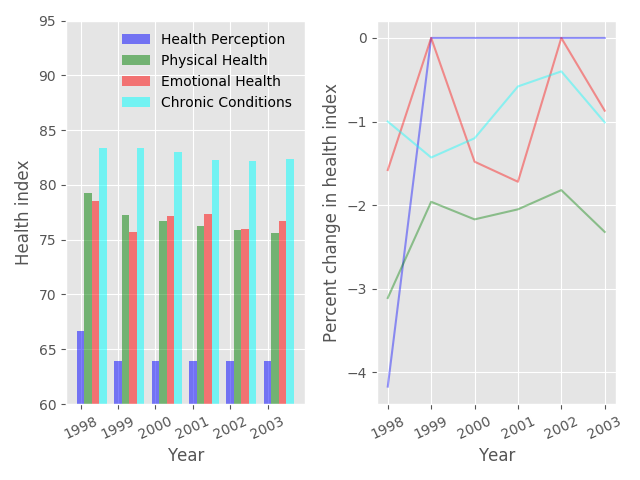

<Container object of 6 artists>

<Container object of 6 artists>

<Container object of 6 artists>

<Container object of 6 artists>

(60, 95)

In [107]:
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import style
style.use('ggplot')
# color_dict={'1': 'red','2':'blue','3':'green','4':'cyan','5':'magenta','6':'yellow','7':'black','8':'rosybrown','9':'seagreen',
#            '10':'chocolate'}
# temp_color=tData['1']['C_EDUC'].apply(lambda x: color_dict.get(x,'white'))
# plt.figure()
# plt.scatter(tData['1']['Health PerceptionA'],tData['1']['Physical HealthA'],s=1,c=temp_color)

c_min=defaultdict(list)
c_max=defaultdict(list)
c_median=defaultdict(list)

for feature in Computables:
    temp_list=[]
    for c in cohorts:
        c_min[feature].append(tData[c][feature].min())
        c_max[feature].append(tData[c][feature].max())
        c_median[feature].append(tData[c][feature].median())

# c_median
change_labels=['Health Perception','Physical Health','Emotional Health','Chronic Conditions']
change_dict=defaultdict(list)
median_dict=defaultdict(list)
for cl in change_labels:
    temp_cl1=cl+'A'
    temp_cl2=cl+'B'
    k=len(c_median[temp_cl2])
    temp_list=[]
    for i in range(k):
        temp_list.append(np.round((c_median[temp_cl2][i]- c_median[temp_cl1][i])/c_median[temp_cl1][i]*100,2))
    change_dict[cl]=temp_list
    median_dict[cl]=c_median[temp_cl1]

ax1=plt.subplot(121)
pos=list(range(6))
width=0.2
colors=['blue','green','red','cyan']
for ind, label in enumerate(change_labels):
    ax1.bar([p + width*ind for p in pos],median_dict[label],width,alpha=0.5,color=colors[ind],label=label)
ax1.legend(frameon=False)
ax1.set_ylim(60,95)
_=ax1.set_xlabel('Year')
_=ax1.set_ylabel('Health index')
_=plt.xticks(range(6),
           ['1998','1999','2000','2001','2002','2003'],rotation=25)

ax2=plt.subplot(122)
for ind,c in enumerate(change_labels):
    _=ax2.plot(change_dict[c],label=c,color=colors[ind],alpha=0.4)
# _=ax2.legend(frameon=False)
_=ax2.set_xlabel('Year')
_=ax2.set_ylabel('Percent change in health index')
_=plt.xticks(range(6),
           ['1998','1999','2000','2001','2002','2003'],rotation=25)

# plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9,hspace=0.3,wspace=0.35)
plt.subplots_adjust(wspace=0.35)
plt.tight_layout()